In [3]:
import hydroeval as he
import time
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split, Subset
# from torchvision import transforms, models
import matplotlib.patches as patches

from datetime import datetime
from pytz import timezone

# import scipy.ndimage
east = timezone('US/Eastern')

In [4]:
def nc2torch(i):
    return torch.from_numpy(np.asarray(i)).unsqueeze(0)

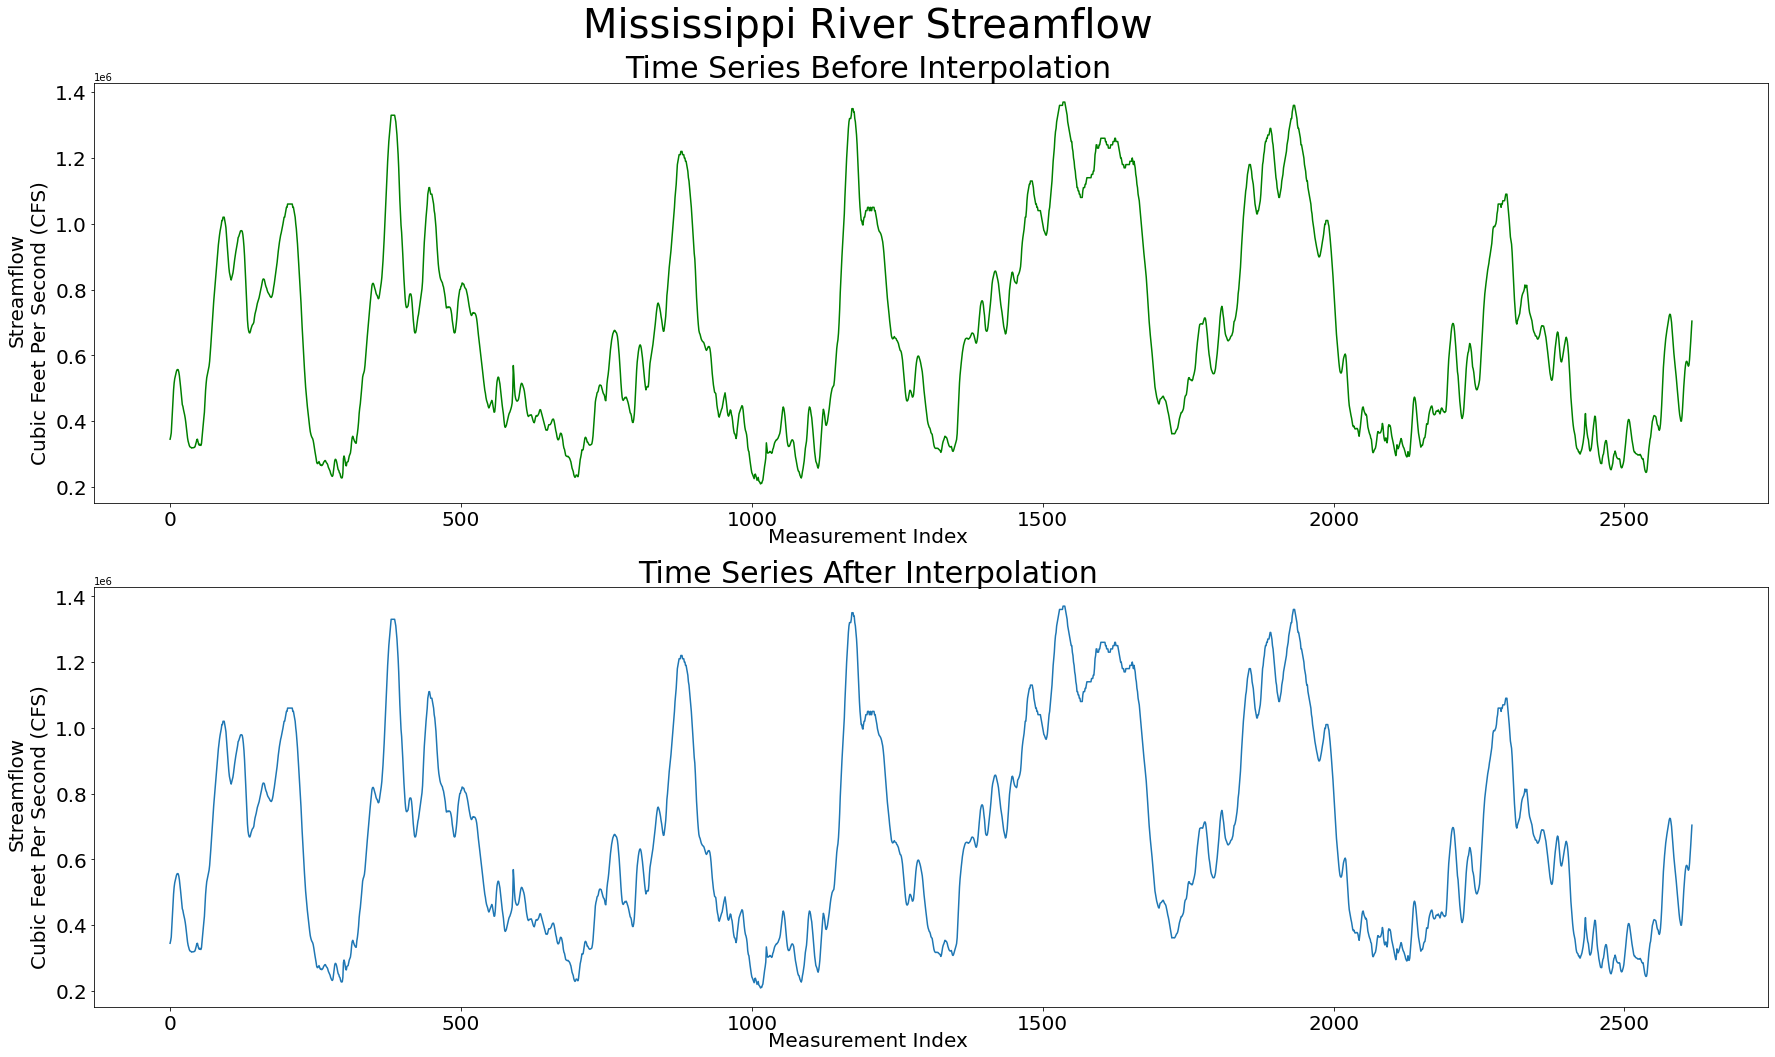

In [19]:
ms_streamz = torch.load('ms_cfs.pt')
ms_streamz.shape
ms_streamz = ms_streamz.numpy()
# ms_streamz = np.where(ms_streamz < -100000,np.nan,ms_streamz) #there's a lesson here
ms_streamz = np.where(ms_streamz < -100000,np.nan,ms_streamz)

fig,ax = plt.subplots(nrows=2,figsize=(30,17))
ax = ax.flatten()
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[0].plot(ms_streamz[:,0,0,0],'green')
# ax[0].scatter(747,800000,s=1000,facecolors='none',edgecolors='#d62728',linewidth=5)
# plt.ylabel('Streamflow \n Cubic Feet Per Second',fontsize=20)


t0 = ax[0].text(
    -280, 800000, "Streamflow", ha="left", va="center", rotation=90, size=20)
t1 = ax[0].text(
    -240, 700000, "Cubic Feet Per Second (CFS)", ha="left", va="center", rotation=90, size=20)
t2_1 = ax[0].text(
    1200, 1470000, "Time Series Before Interpolation", ha="center", va="center", rotation=0, size=30)
t3 = ax[0].text(
    1200, 50000, "Measurement Index", ha="center", va="center", rotation=0, size=20)

# red = patches.Patch(color='#d62728', label='Missing Data')
# ax[0].legend(handles=[red],loc='upper right',fontsize=20)
# ax[0].yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

interp_streamz = pd.Series(ms_streamz[:,0,0,0]).interpolate().tolist()
ax[1].tick_params(axis='both', which='major', labelsize=20)
ax[1].plot(interp_streamz)
# ax[1].scatter(747,800000,s=1000,facecolors='none',edgecolors='pink',linewidth=5)



t0 = ax[1].text(
    -280, 800000, "Streamflow", ha="left", va="center", rotation=90, size=20)
t1 = ax[1].text(
    -240, 700000, "Cubic Feet Per Second (CFS)", ha="left", va="center", rotation=90, size=20)

t2_1 = ax[1].text(
    1200, 1470000, "Time Series After Interpolation", ha="center", va="center", rotation=0, size=30)
t3 = ax[1].text(
    1200, 50000, "Measurement Index", ha="center", va="center", rotation=0, size=20)

t4 = ax[0].text(
    1200,1600000,'Mississippi River Streamflow', ha="center", va="center", rotation=0, size=40)

# pink = patches.Patch(color='pink', label='Interpolated Data')
# ax[1].yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
# ax[1].legend(handles=[pink],loc='upper right',fontsize=20)
# plt.savefig('drive/MyDrive/phd/mississippi/ms_streamflow_before_after_sans.png',bbox_inches='tight')

plt.show()


In [20]:
interp_streamz_pt = torch.from_numpy(np.asarray(interp_streamz)).unsqueeze(1).unsqueeze(1).unsqueeze(1)
interp_streamz_pt.shape
torch.save(interp_streamz_pt,'interp_ms_streamz.pt')

torch.Size([2617, 1, 1, 1])

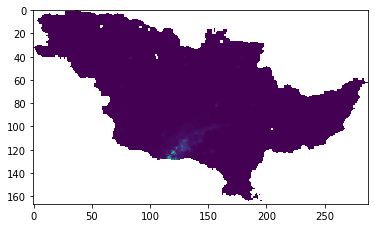

In [67]:
plt.imshow(np.flipud(imz[1000,0]));

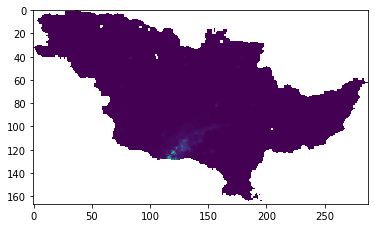

In [65]:
imz_flip = torch.flip(imz,[2])
plt.imshow(imz_flip[1000,0])

In [68]:
imz[:,0].shape

torch.Size([2617, 167, 288])

In [83]:
imz = torch.load('nldas_ms.pt')
imz = torch.flip(imz,[2])
Qs = imz[:,0]
Qsb = imz[:,1]

Qz = [Qs, Qsb]
len(Qz)

zscoredQs = []
for idy,y in enumerate(Qs):
    y = y.numpy()
    y = np.where((y>0) == True,y,np.nan)
    np_nanmean = np.nanmean(y)
    np_nanstd = np.nanstd(y)
    zscored = (y-np_nanmean)/np_nanstd
    zscored = np.where(np.isfinite(zscored) == False, 0, zscored)
    zscored = np.where(zscored<0,0,zscored)
    zscoredQs.append(zscored)
zscoredQs = torch.from_numpy(np.asarray(zscoredQs)).unsqueeze(1)

zscoredQsb = []
for idy,y in enumerate(Qsb):
    y = y.numpy()
    y = np.where((y>0) == True,y,np.nan)
    np_nanmean = np.nanmean(y)
    np_nanstd = np.nanstd(y)
    zscored = (y-np_nanmean)/np_nanstd
    zscored = np.where(np.isfinite(zscored) == False, 0, zscored)
    zscored = np.where(zscored<0,0,zscored)
    zscoredQsb.append(zscored)
zscoredQsb = torch.from_numpy(np.asarray(zscoredQsb)).unsqueeze(1)

print(zscoredQs.shape)
print(zscoredQsb.shape)

zscoredQz = torch.cat((zscoredQs,zscoredQsb),axis=1)
print(zscoredQz.shape)
torch.save(zscoredQz,'zscored_ms_imz.pt')

torch.Size([2617, 1, 167, 288])
torch.Size([2617, 1, 167, 288])
torch.Size([2617, 2, 167, 288])


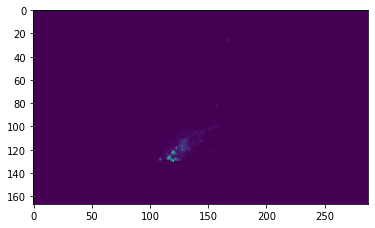

In [82]:
plt.imshow(zscoredQz[1000,0])

In [74]:
# fig,ax = plt.subplots(ncols=2,figsize=(10,10))
# ax = ax.flatten()
# plt1 = ax[0].imshow(imz[0,0],cmap='jet')

# cbr = fig.colorbar(plt1,ax=ax[0],fraction=.052,orientation='horizontal',pad=0.02,ticks=[-999,-500,0])
# cbr.ax.tick_params(labelsize=20)


# plt2 = ax[1].imshow(zscored_imz[0,0],cmap='jet')
# plt.setp(ax, xticks=[], yticks=[])
# cbr = fig.colorbar(plt2,ax=ax[1],fraction=.052,orientation='horizontal',pad=0.02,ticks=[0,0.575,1.15])
# cbr.ax.tick_params(labelsize=20)

# t0 = ax[0].text(
#     140, -25, "SMAP, Mississippi\n Clipped, Raw", ha="center", va="center", rotation=0, size=20)
# t1 = ax[1].text(
#     140, -25, "SMAP, Mississippi\nNoise Filtered, Z-Scored, NaN-Filled", ha="center", va="center", rotation=0, size=20)


# plt.savefig('smap_ms_raw_zscore_sans.png',bbox_inches='tight')
# plt.show()

In [124]:
lag = 14

ms_streamz__for_nn = torch.load('interp_ms_streamz.pt')
ms_imz__for_nn = torch.load('zscored_ms_imz.pt')

ms_streamz__lag = ms_streamz__for_nn[lag:]
ms_imz__lag = ms_imz__for_nn[:-lag]

torch.save(ms_streamz__lag,f'ms_streamz_lag{lag}.pt')
torch.save(ms_imz__lag,f'ms_imz_lag{lag}.pt')

1
NVIDIA GeForce RTX 2080 Ti
shape of x torch.Size([2603, 2, 167, 288])
shape of y torch.Size([2603, 1, 1, 1])
training started at 2022-05-07 15:25:34
nse epoch 0: 	 [0.73083887]
nse epoch 1: 	 [0.70199103]
nse epoch 2: 	 [0.73820071]
nse epoch 3: 	 [0.71143839]
nse epoch 4: 	 [0.81921494]
nse epoch 5: 	 [0.81538767]
nse epoch 6: 	 [0.84509407]
nse epoch 7: 	 [0.76002939]
nse epoch 8: 	 [0.83096184]
nse epoch 9: 	 [0.88907106]
training time 2.65438 minutes


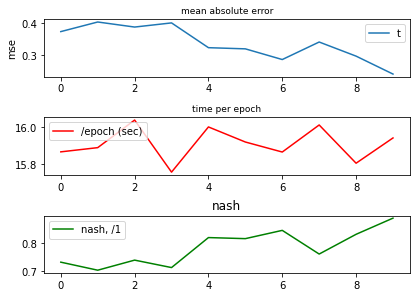

In [128]:
torch.cuda.empty_cache()
torch.cuda.current_device()
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data,1.0,0.02)
        torch.nn.init.constant_(m.bias.data,0)    




class setter2(Dataset):
    def __init__(self,x,y,z):
        self.x = torch.load(x)[:z]
        self.y = torch.load(y)[:z]
        
        self.std,self.mean = torch.std_mean(self.y)

        self.y = (self.y - self.mean)/self.std



        print('shape of x',self.x.shape)
        print('shape of y',self.y.shape)
        
        # self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
        self.y = self.y.reshape(self.y.shape[0],self.y.shape[3])
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]

class LARSONet(torch.nn.Module):
    def __init__(self):
        super(LARSONet,self).__init__()
#         # in layer
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, padding=1, bias=False)
        self.relu = torch.nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(2):
            hidden_layers.append(torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(torch.nn.BatchNorm2d(64))
            hidden_layers.append(torch.nn.ReLU(inplace=True))
        self.mid_layer = torch.nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=1, bias=False) #anything below this is for shrinking 
        
        self.linear1 = torch.nn.Linear(165*286,100)
        self.linear2 = torch.nn.Linear(100,50)
        self.linear3 = torch.nn.Linear(50,20)
        self.linear4 = torch.nn.Linear(20,10)
        self.linear5 = torch.nn.Linear(10,1)

    def forward(self, x):
        out1 = self.relu(self.conv1(x))
        out = self.mid_layer(out1)
        o = self.conv3(out+out1)
        # print('output from conv layer', o.shape) ### important switch
        o = self.linear1(o.view(o.size(0),-1))
        o = self.relu(self.linear2(o))
        o = self.relu(self.linear3(o))
        o = self.relu(self.linear4(o))
        o = self.linear5(o)
        return o

streamz = 'interp_ms_streamz.pt'
imz = 'zscored_ms_imz.pt'

streamz = f'ms_streamz_lag{lag}.pt'
imz = f'ms_imz_lag{lag}.pt'


# nn_ds_size = 1000
dset = setter2(imz,streamz,2603)
cube_height = dset.x.shape[2]
cube_width = dset.x.shape[3]
epochs=10
batch_size=2
# train_dset_size = int(0.85*len(dset))
# valid_dset_size = int(len(dset) - train_dset_size)
# train_dset, valid_dset = random_split(dset,[train_dset_size,valid_dset_size])

train = Subset(dset,range(0,2589))
valid = Subset(dset,range(0,100))


train_dataloader = DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
valid_dataloader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
model = LARSONet()
# model = MLP(cube_height,cube_width)
model.apply(weights_init)
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
criterion = torch.nn.L1Loss(reduction='mean')
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=150,verbose=False)


print('training started at {}'.format(datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')))
t_loss = []
v_loss = []
e_time = []
nse_during = []
t0 = time.time()
for i in range(epochs):
    t_e_loss = 0
    v_e_loss = 0
    train_pred = torch.empty((0,1)).to('cuda')
    train_y = torch.empty((0,1)).to('cuda')
    t00 = time.time()
    model.train()
    for idx,(x,y) in enumerate(train_dataloader):
        optimizer.zero_grad()
        predicted = model(x)
        train_pred = torch.cat((train_pred,predicted.reshape(-1,1)))
        train_y = torch.cat((train_y,y.reshape(-1,1)))
        # print(train_pred.shape)

        # print(predicted.shape)
        # print(y.shape)
#         print(predicted[0])
        loss = criterion(predicted.reshape(-1),y.reshape(-1))
        loss.backward()
        optimizer.step()
        t_e_loss += loss.item()
    for xx,yy in valid_dataloader:
        v_pred = model(xx)
        loss2 = criterion(v_pred.reshape(-1),yy.reshape(-1))
        v_e_loss += loss2.item()
    nse_epoch = he.evaluator(he.nse,train_pred.cpu().detach().numpy(),train_y.cpu().detach().numpy())
    print(f'nse epoch {i}: \t {nse_epoch}')
    nse_during.append(nse_epoch)
    t_loss.append(t_e_loss/len(train_dataloader))
    v_loss.append(v_e_loss/len(valid_dataloader))
    t11 = time.time()
    e_time.append(t11-t00)
t1 = time.time()
print('training time {} minutes'.format(np.format_float_positional((t1-t0)/60,precision=5)))

fig = plt.figure()
fig.add_subplot(311)
plt.title('mean absolute error',fontsize=9)
plt.plot(t_loss)
# plt.plot(v_loss)
plt.legend(['t','v'])
plt.ylabel('mse')
fig.add_subplot(312)
plt.title('time per epoch',fontsize=9)
plt.tight_layout()
plt.plot(e_time,color='red')
# plt.plot(np.cumsum(e_time),color='green')
plt.legend(['/epoch (sec)','cum (min)'])
fig.add_subplot(313)
plt.title('nash')
plt.plot(nse_during,color='green')
plt.legend(['nash, /1'])

shape of x torch.Size([2603, 2, 167, 288])
shape of y torch.Size([2603, 1, 1, 1])
(2603,)
streamz actual mean 662956.5885516711
streamz actual std 308297.1036953611
(2603,)
(2603, 1, 1, 1)
kge [0.80896558] 
r [0.89692518] 
alpha [1.10368907] 
beta [0.87704348]
nse [0.69181429]


<Figure size 1440x720 with 0 Axes>

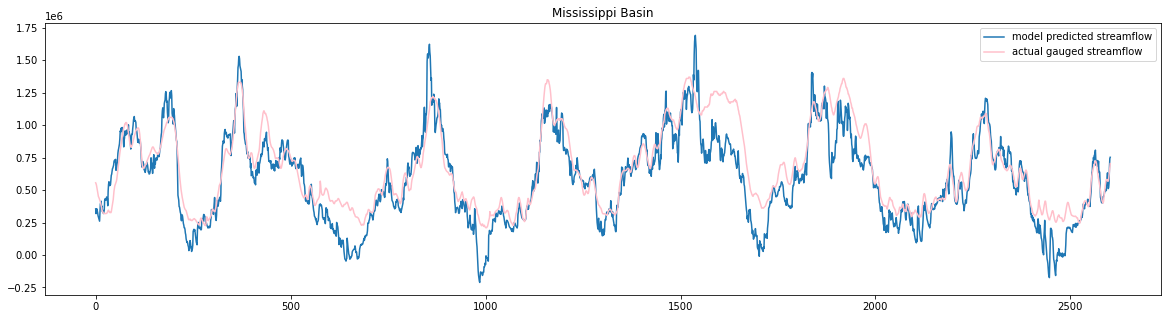

In [129]:
imageTensor = imz
streamTensor = streamz

class setter2infer(Dataset):
    def __init__(self,x,y,z):
        self.x = torch.load(x)[:z]
        self.y = torch.load(y)[:z]
        
        self.std,self.mean = torch.std_mean(self.y)
        self.y = (self.y - self.mean)/self.std

        print('shape of x',self.x.shape)
        
        print('shape of y',self.y.shape)
        
        # self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
        self.y = self.y.reshape(self.y.shape[0],self.y.shape[3])
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)
        return x, y
    def __len__(self):
        return self.x.shape[0]


test_dset = setter2infer(imageTensor,streamTensor,2603)
# test = Subset(test_dset,range(673,841))
train_dataloader = DataLoader(dataset=test_dset, batch_size=1, shuffle=False)


test_predictions = []
with torch.no_grad():
    for xx,yy in train_dataloader:
        test_pred = model(xx)
        # print(test_pred.shape)
        test_predictions.append(test_pred)

test_streamflows = [(x*dset.std)+dset.mean for x in test_predictions]
test_streamflows = torch.Tensor(test_streamflows)
test_streamflows = test_streamflows.numpy()
print(test_streamflows.shape)
# test_streamflows = np.where(test_streamflows>200000,test_streamflows,200000)
streamz_actual = torch.load(streamTensor).numpy()
# targets = np.where(streamz_actual[:,0,0,0]>0,streamz_actual[:,0,0,0],800000)

plt.figure(figsize=(20,10))
x_ax = np.linspace(0,2603,2603)
y = 2 * x_ax; 


print('streamz actual mean',np.mean(streamz_actual))
print('streamz actual std',np.std(streamz_actual))


# ninety_five_confidence = []
# for idx,x in enumerate(streamz_actual):
# #     print(x)
#     if x > (np.mean(streamz_actual) + (3*np.std(streamz_actual))):
#         ninety_five_confidence.append([idx,1])
# #     else:
# #         ninety_five_confidence.append(0)
# ninety_five_confidence = np.asarray(ninety_five_confidence)


# print(ninety_five_confidence.shape)
# print(streamz_actual.shape)

# # plt.plot(ninety_five_confidence[:,0],streamz_actual[ninety_five_confidence[:,0]].reshape(-1),'ro')
# plt.plot(x_ax.reshape(-1),y.reshape(-1),'green')
plt.figure(figsize=(20,5))
plt.plot(test_streamflows)
plt.plot(streamz_actual[:,0,0,0],color='pink')
plt.legend(['model predicted streamflow','actual gauged streamflow'])
plt.title('Mississippi Basin')

print(test_streamflows.shape)
print(streamz_actual.shape)

kge, r, alpha, beta = he.evaluator(he.kge,test_streamflows,streamz_actual[:,0,0,0])
print(f'kge {kge} \nr {r} \nalpha {alpha} \nbeta {beta}')

nse = he.evaluator(he.nse,test_streamflows,streamz_actual[:,0,0,0])
print(f'nse {nse}')

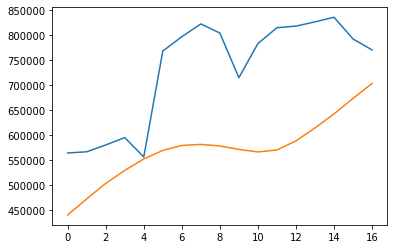

In [116]:
plt.plot(test_streamflows[2600:])
plt.plot(streamz_actual[2600:,0,0,0])